In [2]:
from IPython.display import Image

1) схема устройства GAN
2) dcgan - реализация, обучение, результаты
3) проблемы GAN'ов
4) лоссы для GAN'ов

# Как устроен GAN
![title](\imgs\shema_gan.png)

GAN есть подход для обучения DL моеделей распределению тренировачных данных таком образом, что модель может создавать новые данные из этого распределения.
Подход был разработан Йаном Годфлоу (https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

GAN состоит из двух частей:

1) _**G(z)**_: генератор - создает фейковые изобрадения (_**z**_ - вектор латентного простраства взятый из нормального распределения)
2) _**D(x)**_: дискриминатор - отличает фейковые изображения от настоящих (_**x**_ - образец данный взятый либо из распределения настоящих либо сгенерированный)

_**D(G(z))**_ - вероятность, что выход из генератора является образцом из реального распределения данных.

Генератор и дискриминатор играют в _minmax_ игру. Дискриманатор максимизирует вероятность классификации реального образца и фейка (_log**D(x)**_), а генератор минимизирует вероятность, что его выход дискриминатор классифицирует как фейк (_log ( 1 - **D( G(z) )** )_ )

**Лоссфункция GAN**
![title](\imgs\loss.png)

DC GAN - GAN со сверточными слоями.

 Дискриминатор состоит из сверток со страйдами, слоями батчнормализации и активациями LeakyReLU. Вход есть изображение _3х64х64_, а выход вероятность принадлежности к распределению реальных данных.

 Генератор состоит из convolutional-transpose слоев, батчнормализаций, и ReLU активаций. Вход есть латентный вектор _**z**_, полученный из гауссова распределения, а выход изображение _3х64х64_.

In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
# Дирректория с изображениями
dataroot = "C:\\Users\\Sky\\EveryPixel\\Project_Edu\\img_align_celeba"

# Количество воркеров для сборки датасета
workers = 2

# Размер батча
batch_size = 128*2

# Размер входа сети для изображений. Все изображения ресайзятся к нему
image_size = 64

# Количество каналов цвета
nc = 3

# Размер латентного вектора (размерность латентного пространства)
nz = 100

# Size of feature maps in generator
ngf = 64

# Рамер карты признаков для генератора
ndf = 64

# Кол-во эпох
num_epochs = 5

# Лернингрейт
lr = 0.0002

# Параметр для оптимизатора Adam
beta1 = 0.5

# Количество GPU, 0 если считаем на CPU
ngpu = 1

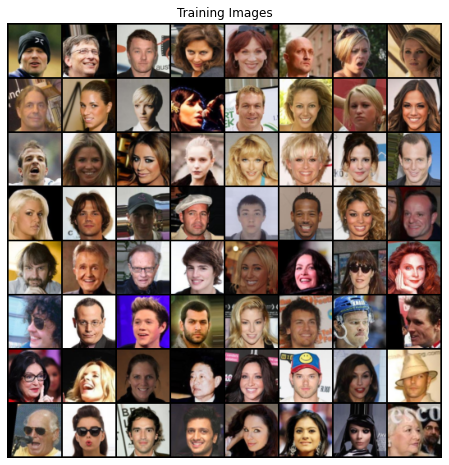

In [5]:
# Для создания датасета используем класс ImageFolder
# Создаем датасет
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Создаем даталоадер
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Выбираем девайс для вычислений
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Нарисуем часть картинок из датасета
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# кастомная инициализация весов netG или netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Генератор отображает латентный вектор _**z**_ в пространство наших данных (из 100 в 3х64х64). Для этого использутся слои convolutional transpose с батчнормализацией и активацией Relu. На выходе тензор пропускается через тангенс и имеет диапазон значений [-1, 1].

![title](\imgs\dcgan.png)

In [7]:
# Имплементация генератора
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # вход Z, идет в convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Инициализируем генератор
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Инициализируем веса
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Дискриминатор - бинарный классификатор, который  оценивает реальное изображение или сгенерированное. На вход изображение _3x64x64_, обрабатывается серией блоков Conv2d+BatchNorm2d+LeakyReLU, выход проходит через сигмоиду. 

In [9]:
# Имплементация дискриминатора

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# инициализируем дискриминатор
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Инициализируем веса
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# Инициализируем лосс
criterion = nn.BCELoss()

# Создаем батч с рандомным шумом для генерации
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Метки для реальных данных и фековых
real_label = 1.
fake_label = 0.

# Устанавливаем оптимизаторы для G и D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Для обучения GAN будем следовать алгоритму I из статьи Годфлоу. На самом деле есть много трюков при обучении GAN'ов, их можно посмотреть здесь https://github.com/soumith/ganhacks. Обучние состоит из 2ух частей:

1) обучение дискриминатора
2) обучение генератора

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# Для каждой эпохи
for epoch in range(num_epochs):
    # Для каждого батча
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Для батча
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Прямой прогон батча из реальных картинок D
        output = netD(real_cpu).view(-1)
        # Считаем лосс на всем батче реальных картинок
        errD_real = criterion(output, label)
        # Вычисляем градиенты для дискриминатора
        errD_real.backward()
        D_x = output.mean().item()

        ## Учим на полном фейковом батче
        # Генерируем бат латентных векторов
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Генерируем фековый батч с помощью G
        fake = netG(noise)
        label.fill_(fake_label)
        # Классифицируем фековый батч с помощью D
        output = netD(fake.detach()).view(-1)
        # Вычисляем лосс дискриминатора на фейковом батче
        errD_fake = criterion(output, label)
        # Вычисляем градиент для фейкового батча, он суммируется с предидущим
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Вычисляем ошибку на реальном и фековом батчах
        errD = errD_real + errD_fake
        # Обновляем веса D
        optimizerD.step()

        ############################
        # (2) Учим генератор: максимизируем log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # для генератора фейковые метки есть реальные (0 меняем на 1)
        # Так как мы обновили веса дискриминатора прогоним фековый батч через него еще  раз
        output = netD(fake).view(-1)
        # Вычислим лосс G основываясь на выходе D
        errG = criterion(output, label)
        # Вычислим градиент для G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Обновляем веса G
        optimizerG.step()

        # Выводим статистику обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Сохраним лоссы
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Проверим какие картинки рисует генератор
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/792]	Loss_D: 1.7683	Loss_G: 5.0992	D(x): 0.5359	D(G(z)): 0.5728 / 0.0108
[0/5][50/792]	Loss_D: 0.1234	Loss_G: 26.7071	D(x): 0.9344	D(G(z)): 0.0000 / 0.0000
[0/5][100/792]	Loss_D: 0.3653	Loss_G: 6.2500	D(x): 0.9245	D(G(z)): 0.2026 / 0.0086
[0/5][150/792]	Loss_D: 0.3880	Loss_G: 2.7804	D(x): 0.8634	D(G(z)): 0.1355 / 0.0992
[0/5][200/792]	Loss_D: 0.7105	Loss_G: 4.2478	D(x): 0.6969	D(G(z)): 0.0882 / 0.0324
[0/5][250/792]	Loss_D: 1.0777	Loss_G: 1.9365	D(x): 0.4676	D(G(z)): 0.0287 / 0.2084
[0/5][300/792]	Loss_D: 0.5683	Loss_G: 3.3593	D(x): 0.7937	D(G(z)): 0.2233 / 0.0537
[0/5][350/792]	Loss_D: 0.4734	Loss_G: 4.0238	D(x): 0.7554	D(G(z)): 0.0699 / 0.0339
[0/5][400/792]	Loss_D: 0.4108	Loss_G: 3.3984	D(x): 0.8078	D(G(z)): 0.1048 / 0.0555
[0/5][450/792]	Loss_D: 0.2720	Loss_G: 3.3614	D(x): 0.8768	D(G(z)): 0.0967 / 0.0690
[0/5][500/792]	Loss_D: 0.6461	Loss_G: 4.3094	D(x): 0.6562	D(G(z)): 0.0496 / 0.0282
[0/5][550/792]	Loss_D: 1.0421	Loss_G: 9.2938	D(x): 0.9458	D(G(z

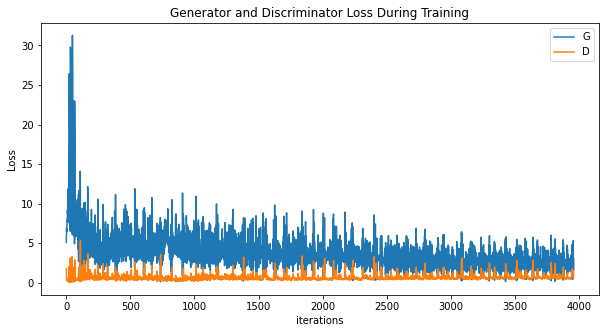

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

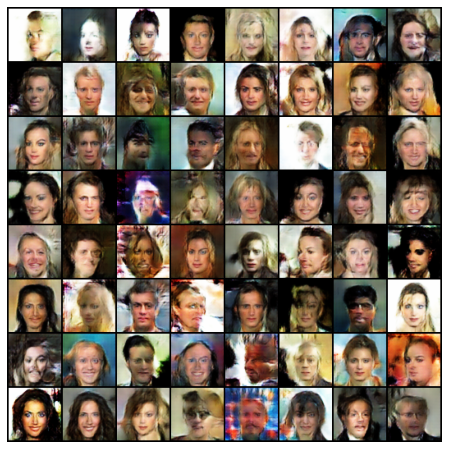

In [15]:
##%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

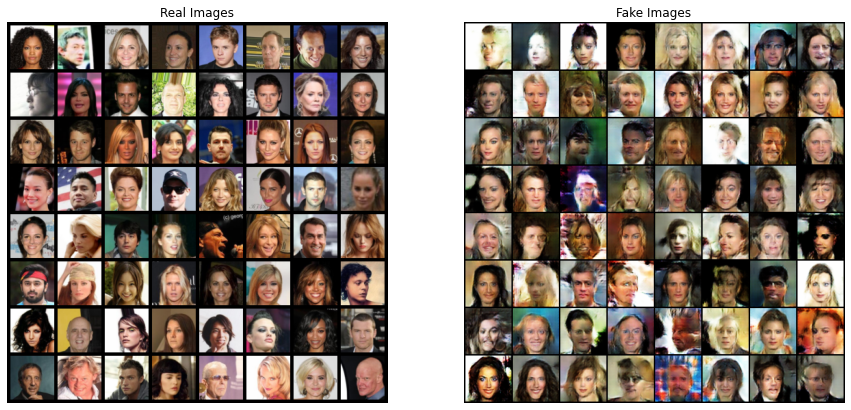

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

ДЗ:
1) прочитать статью https://arxiv.org/ftp/arxiv/papers/2006/2006.05132.pdf
2) прочитать 
Chapter 5. Training and common challenges: GANing for success